In [ ]:
"""
To practice extracting the axon automatically using the 
newly created filtering rules

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import sys
sys.path.append("/meshAfterParty/")

In [18]:
from importlib import reload

import neuron_utils as nru

import neuron

import neuron_visualizations as nviz

import time

import datajoint_utils as du

import numpy as np

import proofreading_utils as pru

import preprocessing_vp2 as pre

# -- For the axon classification --

import neuron_searching as ns

import skeleton_utils as sk

import numpy_utils as nu

import networkx_utils as xu

# Importing Neuron

In [4]:
neuron_obj_file = "classic_double_neuron_1"

In [5]:
curr_neuron_obj = nru.decompress_neuron(neuron_obj_file,neuron_obj_file)

Decompressing Neuron in minimal output mode...please wait


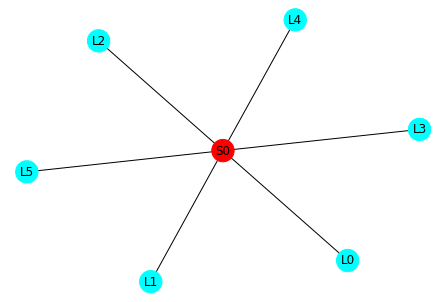

In [7]:
nviz.plot_soma_limb_concept_network(curr_neuron_obj)

In [8]:
nviz.visualize_neuron(curr_neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton


# 0) Check that only one soma

In [9]:
soma_names = curr_neuron_obj.get_soma_node_names()
if len(soma_names)>1:
    raise Exception(f"More than 1 soma: {soma_names}")

soma_name = soma_names[0]

In [87]:
verbose = True
ais_threshold = 10000

# 1) Classify All Axon Segments

In [33]:
axon_like_limb_branch_dict = ns.axon_width_like_segments(curr_neuron_obj,
                                                        include_ais=True)



# nviz.visualize_neuron(curr_neuron_obj,
#                       visualize_type=["mesh"],
#                      limb_branch_dict=axon_like_limb_branch_dict,
#                      mesh_color="red",
#                       mesh_color_alpha=1,
#                      mesh_whole_neuron=True)

current_functions_list = ["axon_segment"]
final_axon_like_classification = ns.query_neuron(curr_neuron_obj,
                                        
                                   query="axon_segment==True",
                                   function_kwargs=dict(limb_branch_dict =axon_like_limb_branch_dict,
                                                        downstream_face_threshold=3000,
                                                        width_match_threshold=50,
                                                       print_flag=False),
                                   functions_list=current_functions_list)

nviz.visualize_neuron(curr_neuron_obj,
                      visualize_type=["mesh"],
                     limb_branch_dict=final_axon_like_classification,
                     mesh_color="red",
                      mesh_color_alpha=1,
                     mesh_whole_neuron=True)

current_query = (n_spines < 4 and (median_mesh_center < 600) and skeleton_distance_branch <= 15000) or (skeleton_distance_branch > 15000 and (median_mesh_center < 600) and spines_per_skeletal_length < 0.00023)
functions_list = [<function width at 0x7f5ea2455a60>, <function median_mesh_center at 0x7f5ea2455d08>, <function n_spines at 0x7f5ea2455b70>, <function n_faces_branch at 0x7f5ea24558c8>, <function skeleton_distance_branch at 0x7f5ea2455ae8>, <function spines_per_skeletal_length at 0x7f5ea26bd048>, <function no_spine_median_mesh_center at 0x7f5ea2455e18>]
functions_list = [<function axon_segment at 0x7f5ea26bd730>]

 Working on visualization type: mesh


In [34]:
# want to label all branches as "axon_like"
current_label = "axon-like"

nru.add_branch_label(curr_neuron_obj,
                    limb_branch_dict=final_axon_like_classification,
                    labels=current_label)


In [35]:
current_functions_list = ["matching_label"]

recovered_axon_branches = ns.query_neuron(curr_neuron_obj,
                query="matching_label==True",
                function_kwargs=dict(labels =["axon-like"]),
                functions_list=current_functions_list
               )

recovered_axon_branches

functions_list = [<function matching_label at 0x7f5ea26bd0d0>]


{'L0': array([ 1,  3,  5,  7,  8, 16, 18, 20, 21, 38, 45]),
 'L1': array([ 3,  4,  9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22]),
 'L2': array([ 4,  6,  8,  9, 11, 12, 13, 14, 15, 16, 23]),
 'L4': array([0]),
 'L5': array([3])}

# 2) Filter Limbs By Starting Angle

In [36]:
axon_soma_angle_threshold = 70

soma_center = curr_neuron_obj["S0"].mesh_center

possible_axon_limbs_dict = ns.query_neuron(curr_neuron_obj,
                query=f"soma_starting_angle>{axon_soma_angle_threshold}",
               functions_list=[ns.soma_starting_angle],
               function_kwargs=dict(soma_center=soma_center,
                                   verbose=True))

possible_axon_limbs = list(possible_axon_limbs_dict.keys())
possible_axon_limbs = [nru.get_limb_int_name(k) for k in possible_axon_limbs]
possible_axon_limbs

functions_list = [<function soma_starting_angle at 0x7f5ea26bda60>]
Limb L0 soma angle: 2.56 
Limb L1 soma angle: 106.07 
Limb L2 soma angle: 98.8 
Limb L3 soma angle: 122.76 
Limb L4 soma angle: 134.4 
Limb L5 soma angle: 106.31 


[1, 2, 3, 4, 5]

# 3) Get all of the Viable Candidates

In [37]:
import classification_utils as clu

In [38]:
axon_subgraph_candidates = clu.axon_candidates(curr_neuron_obj,
                   possible_axon_limbs=possible_axon_limbs,
                        ais_threshold=ais_threshold,
                   plot_candidates_after_adding_back=True,
                   verbose=True)

functions_list = [<function skeletal_distance_from_soma at 0x7f5ea26bd598>]
functions_list = [<function skeletal_distance_from_soma at 0x7f5ea26bd598>]

Working on Limb L1
nodes_to_eliminate = []

Working on Limb L2
nodes_to_eliminate = [20 22]

Working on Limb L3
nodes_to_eliminate = [3]

Working on Limb L4
nodes_to_eliminate = [0]
The filtered network is empty so just leaving the candidates as empty lists

Working on Limb L5
nodes_to_eliminate = []

----Working on Limb L1-----
No nodes were eliminated so don't need to add back any candidates

----Working on Limb L2-----
No endpoints were eliminated so don't need to add back any candidates

----Working on Limb L3-----
No endpoints were eliminated so don't need to add back any candidates

----Working on Limb L4-----
network was only of size 1 and that node was eliminated so returning that as the only candidate

----Working on Limb L5-----
No nodes were eliminated so don't need to add back any candidates

 Working on visualization type:

Final Candidates

Limb 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Limb 2
[2]
[ 0  3  6  7 10]
[ 1  4  5  8  9 11 12 13 14 15 16 17 18 19 21 23 24]

Limb 3
[0 1 2]
[4 5 6]

Limb 4
[0]

Limb 5
[0 1 2 3 4 5]


In [56]:
curr_candidate_subgraph

array([2])

In [57]:
nviz.visualize_neuron(curr_neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict=dict(L2=[2]))


 Working on visualization type: mesh

 Working on visualization type: skeleton


# Doing the Filtering of the Candidates

In [39]:
import networkx_utils as xu
import networkx as nx

In [40]:
"""
Pseudocode: 

For each candidate: 

0) If all Axon? (Have a more relaxed threshold for the skeleton angle)
1) Find the starting direction, and if not downwards --> then not axon
2) ------------- Check if too thin at the start --> Not Axon (NOT GOING TO DO THIS) -------------
3) If first branch is axon --> classify as axon
4) Trace back to starting node and add all branches that are axon like

"""

axon_subgraph_candidates_passing_angle_filter = dict()

'\nPseudocode: \n\nFor each candidate: \n\n0) If all Axon? (Have a more relaxed threshold for the skeleton angle)\n1) Find the starting direction, and if not downwards --> then not axon\n2) ------------- Check if too thin at the start --> Not Axon (NOT GOING TO DO THIS) -------------\n3) If first branch is axon --> classify as axon\n4) Trace back to starting node and add all branches that are axon like\n\n'

In [91]:
curr_limb_idx = 2
curr_limb_name = nru.get_limb_string_name(curr_limb_idx)
curr_limb = curr_neuron_obj[curr_limb_idx]
curr_candidate_idx = 1
curr_candidate_subgraph = np.array(axon_subgraph_candidates[curr_limb_idx][curr_candidate_idx])
curr_candidate_subgraph,curr_limb_name

(array([ 0,  3,  6,  7, 10]), 'L2')

In [93]:
nviz.visualize_neuron(curr_neuron_obj,
                      visualize_type=["mesh","skeleton"],
                     limb_branch_dict={f"L{curr_limb_idx}":curr_candidate_subgraph})


 Working on visualization type: mesh

 Working on visualization type: skeleton


In [94]:
true_axon_branches = []

# Part A: Filtering For Axon Composition

In [104]:
"""
Pseudocode: 
1) Get the number of branches in the candidate that are axons
2a) If all are axons --> choose the relaxed axon angle threshold
2b) If none are axons --> remove as not a candidate
2c) if some are --> use standard axon threshold

"""

axon_angle_threshold_relaxed = 100
axon_angle_threshold = 120
relaxation_percentage = 85

axon_branches_on_limb = final_axon_like_classification[curr_limb_name]
axon_branches_on_subgraph = np.intersect1d(axon_branches_on_limb,curr_candidate_subgraph)

axon_percentage = len(axon_branches_on_subgraph)/len(curr_candidate_subgraph)

if verbose:
    print(f"{len(axon_branches_on_subgraph)} out of {len(curr_candidate_subgraph)} branches are axons")
    print(f"Axon percentage = {axon_percentage}")
if axon_percentage > relaxation_percentage:
    curr_axon_angle_threshold = axon_angle_threshold_relaxed
elif len(axon_branches_on_subgraph) == 0:
    true_axon_branches = []
    raise Exception("Done processing candidate")
else:
    curr_axon_angle_threshold = axon_angle_threshold
    
if verbose:
    print(f"curr_axon_angle_threshold = {curr_axon_angle_threshold}")
    

1 out of 5 branches are axons
Axon percentage = 0.2
curr_axon_angle_threshold = 120


# Part B: Filtering For Starting Skeleton Angle

In [105]:
curr_limb.set_concept_network_directional(starting_soma = 0)

In [106]:
undirectional_limb_graph = nx.Graph(curr_limb.concept_network_directional)

current_shortest_path,st_node,end_node = xu.shortest_path_between_two_sets_of_nodes(
    undirectional_limb_graph,[curr_limb.current_starting_node],
    curr_candidate_subgraph)

candidate_nodes = np.unique(np.hstack([curr_candidate_subgraph,current_shortest_path]))
candidate_nodes

array([ 0,  3,  6,  7, 10, 20, 22])

In [107]:
import networkx as nx

    
    
    
candidate_angles,restr_skels = clu.candidate_starting_skeletal_angle(limb_obj=curr_limb,
                                  candidate_nodes=candidate_nodes,
                                      offset = ais_threshold,
                                    axon_sk_direction_comparison_distance = 10000,
                                    buffer_for_skeleton = 5000,
                                      top_volume_vector = np.array([0,-1,0]),
                                      plot_skeleton_paths_before_restriction=False,
                                      plot_skeleton_paths_after_restriction=True,
                                                     return_restricted_skeletons=True,
                                      verbose=True,
                                     )

sk_passing_threshold = np.where(candidate_angles>curr_axon_angle_threshold)[0]
sk_passing_threshold

endnodes_to_test = [962]
Skeleton paths distances = [24955.63367314]
Filtered indexes = [0]
len(filtered_skeletons) = 1


sk_angles = [128.0149632]


array([0])

In [ ]:
if len(sk_passing_threshold) == 0:
    true_axon_branches = []
    raise Exception("Done processing candidate")

# Part C: Filtering by Axon Being the Current Starting Piece

In [117]:
candidate_starting_node = current_shortest_path[-1]
if candidate_starting_node not in axon_branches_on_limb:
    true_axon_branches = []
    raise Exception("Done processing candidate")

Exception: Done processing candidate

In [115]:
# Part D: Add all of the candidates branches and those backtracking to mesh that are axon-like
extra_nodes_to_add = np.intersect1d(axon_branches_on_limb,current_shortest_path[:-1])
true_axon_branches = np.hstack([curr_candidate_subgraph,extra_nodes_to_add])
true_axon_branches

array([ 0,  3,  6,  7, 10])

In [116]:
current_shortest_path

[22, 20, 10]

# Funciton that Processes all candidates

In [132]:
ns.query_neuron

[autoreload of classification_utils failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/meshAfterParty/classification_utils.py", line 446
    axon_candidate_filt

In [184]:
final_true_axons = clu.filter_axon_candiates(
    curr_neuron_obj,
    axon_subgraph_candidates,
    axon_angle_threshold_relaxed = 100,
    axon_angle_threshold = 120,
    relaxation_percentage = 85,
    axon_like_limb_branch_dict=None,
    verbose = True,
    )

functions_list = [<function matching_label at 0x7f5e83acb378>]


 --- Working on limb 1, candidate # 0
13 out of 24 branches are axons
Axon percentage = 0.5416666666666666
curr_axon_angle_threshold = 120
endnodes_to_test = [169]
Skeleton paths distances = [24973.65193482]
Filtered indexes = [0]
len(filtered_skeletons) = 1
sk_angles = [101.76314944]
Not adding candidate because no angles ([101.76314944]) passed the threhold 120 


 --- Working on limb 2, candidate # 0
0 out of 1 branches are axons
Axon percentage = 0.0
Not adding candidate no axon branches detected 
curr_axon_angle_threshold = 120
endnodes_to_test = [363]
Skeleton paths distances = [24985.83163314]
Filtered indexes = [0]
len(filtered_skeletons) = 1
sk_angles = [94.99871289]
Not adding candidate because no angles ([94.99871289]) passed the threhold 120 


 --- Working on limb 2, candidate # 1
1 out of 5 branches are axons
Axon percentage = 0.2
curr_axon_angle_threshold = 120
endnodes_to_test = [962]
Skeleton paths distan

In [186]:
final_true_axons

{'L4': array([0.])}

In [128]:
nviz.visualize_neuron(curr_neuron_obj,
                     limb_branch_dict=dict(L4=[0]))


 Working on visualization type: mesh

 Working on visualization type: skeleton


In [189]:
curr_neuron_obj["L4"]

In [191]:
nviz.visualize_neuron(curr_neuron_obj,
                              visualize_type=["mesh"],
                             limb_branch_dict=final_true_axons,
                             mesh_color="red",
                              mesh_color_alpha=1,
                             mesh_whole_neuron=True)


 Working on visualization type: mesh


In [190]:
debug

> /usr/local/lib/python3.6/dist-packages/networkx/classes/reportviews.py(178)__getitem__()
    176 
    177     def __getitem__(self, n):
--> 178         return self._nodes[n]
    179 
    180     # Set methods

ipdb> self._nodes
{'S0': {'data': <neuron.Soma object at 0x7f5e7ab72f28>}, 'L0': {'data': <neuron.Limb object at 0x7f5e7ab72f98>}, 'L1': {'data': <neuron.Limb object at 0x7f5e7ab570b8>}, 'L2': {'data': <neuron.Limb object at 0x7f5e7ab571d0>}, 'L3': {'data': <neuron.Limb object at 0x7f5e7ab72cf8>}, 'L4': {'data': <neuron.Limb object at 0x7f5e7a7dfef0>}, 'L5': {'data': <neuron.Limb object at 0x7f5e7a843a58>}}
ipdb> c


# Final Part: Adding the labels to the Neuron

In [150]:
nru.clear_all_branch_labels(curr_neuron_obj,"axon")

['axon-like']

In [175]:
nru.add_branch_label(curr_neuron_obj,
                    limb_branch_dict=final_ture_axons,
                    labels="axon")

In [176]:
curr_neuron_obj[4][0].labels#.append("axon")

['axon-like', 'axon']

# Now be able to search neuron for axons and others as errors

In [181]:
ns.query_neuron_by_labels(curr_neuron_obj,
                         matching_labels = ["axon-like"],
                         #not_matching_labels = ["axon"]
                         )

functions_list = [<function labels_restriction at 0x7f5e83acb268>]


{'L0': array([ 1,  3,  5,  7,  8, 16, 18, 20, 21, 38, 45]),
 'L1': array([ 3,  4,  9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22]),
 'L2': array([ 4,  6,  8,  9, 11, 12, 13, 14, 15, 16, 23]),
 'L4': array([0]),
 'L5': array([3])}